<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
<img src="https://www.bbva.com/wp-content/uploads/2019/04/Logo-BBVA-1024x576.jpg" width="200" height="100" float ="right">
    
---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Análisis inicial
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


- **Strings**

In [2]:
from collections import Counter
import re

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [3]:
dir_in, dir_out = "../../datos/datos_originales/", ""

In [4]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        path = os.getcwd()
        csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []

        for i in csv_files:
            temp_df = pd.read_csv(i)
            dataframes_list.append(temp_df)
        
        return dataframes_list
    
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

In [5]:
cd = carga_datos ()

## Funciones a utilizar
---

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [6]:
def get_family_name(id_):
    
    filtered = product[product.family_id == id_]
    string = ' '.join(filtered.title).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

____

In [7]:
dfs = cd.subir_tablas(dir_in)
titulos = os.listdir(dir_in)

### Unión de *dataframes*

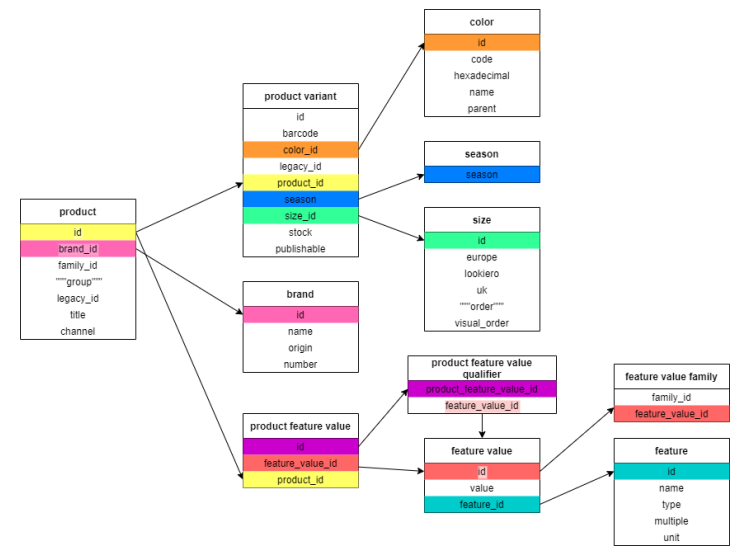

#### 1) df_total =  product variant + color + size + season

- **Season**: No utilizar
- **Size**: Utilizar solo la talla creada por *lookiero*
- **Color**: Utilizar solo el nombre del color

product_variant + size = 116 not used sizes NAN  
product_variant_size + color = 1 not used color (mixt) NAN

In [8]:
df_total = dfs[-1].merge(dfs[0][['id', 'lookiero']], left_on ='size_id', right_on = 'id', suffixes = ('', '_size')).drop(['id_size', 'size_id'], axis = 1)
df_total = df_total.merge(dfs[1][['id', 'name']], left_on ='color_id', right_on = 'id', suffixes = ('', '_color')).drop(['id_color', 'color_id', 'legacy_id'], axis = 1)
df_total.columns = list(df_total.columns[:-2]) + ['size_lookiero', 'color']
df_total['size_lookiero'] = pd.Series([string.split()[1][:-1].replace('"', '') for string in df_total.size_lookiero])

#### 2) df_total += product

- **Product**: Dar nombre a la variable family_id y eliminar *legacy_id* y *channels*

# FUCK
product_variant + product = 41291 (63'3%) with no product_family or brand NAN  
NO SÉ SI SON COAT, SCARF O QUÉ...  
23935 SIN NAN

In [9]:
product = dfs[7].drop(['legacy_id', 'channels'], axis = 1)

parejas = dict(map(get_family_name, product.family_id.unique()))
product['product_family'] = product.family_id.map(parejas)
product = product.drop(['family_id', 'title', '"group"'], axis = 1)

df_total = df_total.merge(product, left_on = 'product_id', right_on = 'id', suffixes = ('', '_product')).drop('product_id', axis = 1)

#### 3) df_total += brand

- **brand**: No utilizar variable number

df_total + brand = 0 NAN

In [10]:
brand = dfs[5].drop('number', axis = 1)
brand.columns = ['id', 'brand', 'brand_origin']
df_total.publishable = df_total.publishable.map({'f': False, 't': True})
df_total = df_total.merge(brand, left_on = 'brand_id', right_on = 'id', suffixes = ('', '_brand')).drop(['id_brand', 'brand_id'], axis = 1)

#### 4) values = feature values + feature (*value caracteristics*)

- **feature**: Multiple convertir en booleano (borrar??) y para poder eliminar la variable unit pasar los porcentajes a decimales (para diferenciarlos)

feature + feature_value = 1 value caracteristic not used NAN

In [11]:
feature = dfs[6].copy()
feature.multiple = feature.multiple.map({'f': False, 't': True})
feature.columns = ['id', 'feature_name', 'feature_type', 'feature_multiple', 'unit']

feature_value = dfs[4]
values = feature_value.merge(feature, left_on = 'feature_id', right_on = 'id', suffixes = ('', '_values')).drop(['id_values','feature_id'], axis = 1)
values.loc[values.unit == 'PERCENTAGE', 'value'] = values.loc[values.unit == 'PERCENTAGE', 'value'].astype('float') / 100

feature_family no sirve para nada **creo** por lo que las siguientes celda en raw

#### 5) values + value family

In [ ]:
dfs[11].columns = ['feature_family', 'feature_value_id']
values = values.merge(dfs[11], left_on = 'id', right_on = 'feature_value_id').drop('feature_value_id', axis = 1)

#### 6) product_values = values + product_feature_value

values + product_feature_value = 1420 (1'84%) caracteristics that has no product NAN

In [12]:
product_values = values.merge(dfs[9], left_on = 'id', right_on = 'feature_value_id', suffixes = ('_values', '_product_feature')).drop('feature_value_id', axis = 1)

#### 7) product_values + df_total

products + features = 383 (0'06%) products without caracteristics NAN

In [13]:
df = df_total.merge(product_values, left_on = 'id_product', right_on = 'product_id').drop('product_id', axis = 1)

id = Un único producto (se repite pork tiene diferentes features)  
id_product = El producto en general (niki manga larga)  
id_values = id de una característica
id_product_feature = id de la característica de un producto en general (id_product)

In [21]:
df

,id,barcode,season,stock,publishable,size_lookiero,color,id_product,product_family,brand,brand_origin,id_values,value,feature_name,feature_type,feature_multiple,unit,id_product_feature
0,0f81d5a7-fdc4-493a-a5b8-73e04a1516ca,999335,8,22,True,S,black,39ad707f-8578-4ff9-9114-49dce0e286dc,coat,BRAND132,NO_MAINSTREAM,557c07c7-d117-478a-8510-fd94a8a78f4a,51,waist_contour,NUMBER,False,CENTIMETERS,bb3c12e6-863d-4ccd-8017-140f82f49728
1,0f81d5a7-fdc4-493a-a5b8-73e04a1516ca,999335,8,22,True,S,black,39ad707f-8578-4ff9-9114-49dce0e286dc,coat,BRAND132,NO_MAINSTREAM,60296bfe-a279-436e-85d1-65dc76641e46,tall_clients,alerts,STRING,True,\N,22c0b97c-0d83-4ded-b601-324513a842bf
2,0f81d5a7-fdc4-493a-a5b8-73e04a1516ca,999335,8,22,True,S,black,39ad707f-8578-4ff9-9114-49dce0e286dc,coat,BRAND132,NO_MAINSTREAM,d713ce35-ad6b-4f65-b7c1-ba2b4a5507ed,86,long_cm,NUMBER,False,CENTIMETERS,123dda15-d41d-423c-9463-3309efb2d46d
3,0f81d5a7-fdc4-493a-a5b8-73e04a1516ca,999335,8,22,True,S,black,39ad707f-8578-4ff9-9114-49dce0e286dc,coat,BRAND132,NO_MAINSTREAM,df09f3d5-66e8-4c7a-819a-7a857878ccbf,cuffed_sleeve,sleeve,STRING,True,\N,c3d2f8e8-4460-46fe-8000-295a754ea339
4,0f81d5a7-fdc4-493a-a5b8-73e04a1516ca,999335,8,22,True,S,black,39ad707f-8578-4ff9-9114-49dce0e286dc,coat,BRAND132,NO_MAINSTREAM,e7f48be6-fbd3-41bf-b865-d7e1615e09a0,basic_sleeve,sleeve,STRING,True,\N,ce155ba4-9d63-4abe-8df8-9a76e3b807ce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620324,df7d2078-03de-407e-bb76-b1ec6e081066,1359671,9,0,True,XS,indigo,284050c3-1b0e-450c-ba8a-94fe97cd380a,jacket,BRAND14,NO_MAINSTREAM,877425b0-3bed-4c99-97de-09a53c508058,cold_season,weather,STRING,True,\N,b6c12479-517a-433a-8756-7ce8147ffb51
620325,df7d2078-03de-407e-bb76-b1ec6e081066,1359671,9,0,True,XS,indigo,284050c3-1b0e-450c-ba8a-94fe97cd380a,jacket,BRAND14,NO_MAINSTREAM,4acbd0b8-76aa-458b-b167-3fa7f1a25b63,true,label,BOOLEAN,False,\N,b9356c40-61e8-4743-9fb8-3acd975e5b3e
620326,df7d2078-03de-407e-bb76-b1ec6e081066,1359671,9,0,True,XS,indigo,284050c3-1b0e-450c-ba8a-94fe97cd380a,jacket,BRAND14,NO_MAINSTREAM,c44d9726-b895-4392-a4cf-57af3ffca7c4,false,gripper,BOOLEAN,False,\N,edba5798-3d51-4c7e-b149-34714125c661
620327,df7d2078-03de-407e-bb76-b1ec6e081066,1359671,9,0,True,XS,indigo,284050c3-1b0e-450c-ba8a-94fe97cd380a,jacket,BRAND14,NO_MAINSTREAM,7ea070fc-bddb-4f09-a533-56347fa782a3,medium,thicknees,STRING,False,\N,7edd692e-cf7f-41cf-82b0-adafde07d639
